<br>

## Installlation and imports

Install `esm` (https://github.com/facebookresearch/esm)

In [ ]:
!pip install fair-esm

<br>

Import libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import esm
import time

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
from torch.utils.data import Dataset, DataLoader

<br>

Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<br>

Init pre-trained ESM model and alphabet (this may take about 5min)

In [ ]:
esm_model, alphabet = esm.pretrained.esm.pretrained.esm1b_t33_650M_UR50S()

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt


<br>

Init batch converter

In [ ]:
batch_converter = alphabet.get_batch_converter()

<br>

## Load data

In [ ]:
# fname = '/content/drive/Othercomputers/My MacBook Pro/MIE1517_nlp_proteins/data/postprocessedECnumToSeq-edited.csv' #Tomas dir
fname = '/content/drive/MyDrive/Colab Notebooks/Protein Sequence Analysis/postprocessedECnumToSeq-edited.csv' #Rana dir
seq_data = pd.read_csv(
    fname, 
    index_col = 0    
)

In [ ]:
seq_data.head()

,EC Number,Level 1,Level 2,Level 3,Level 4,sequence
0,1,1,NaN,NaN,NaN,TKDNLTGDIVIIGAGAAGSLLAHYLARFSNMKIILLEAGHSHFNDP...
1,1,1,NaN,NaN,NaN,MHHHHHHSSGVDLGTENLYFQSNAMNISRKTALVTGASRGIGRAIA...
2,1,1,NaN,NaN,NaN,QGMIMTSDIKLLDYLRVRRSTPALQLSEPGPSKGEIEEILRLAVRV...
3,1,1,NaN,NaN,NaN,AMVSSSCSSIPKMPVTPLSLVTRHVAIIGAGAAGLVTARELRREGH...
4,1,1,NaN,NaN,NaN,MADLNQRRQRSEFQSKIKILLSTTIKAKPELVPSLLKLALNDAMTY...


In [ ]:
print(seq_data.shape)

(16994, 6)


<br>

## Perform data pre-processing

<br>

Subset columns

In [ ]:
cols = ['EC Number', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'sequence']
seq_data = seq_data[cols]

<br>

Change column names

In [ ]:
seq_data.columns = ['ECNumber', 'Level_1', 'Level_2', 'Level_3', 'Level_4', 'sequence']

<br>

Drop NaNs

In [ ]:
seq_data = seq_data.dropna(subset = ['sequence'])

<br>

Add column with sequence length

In [ ]:
seq_data.loc[:,'seg_length'] = seq_data['sequence'].apply(len)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


<br>

Plot histogram of sequence length and highlight the threshold

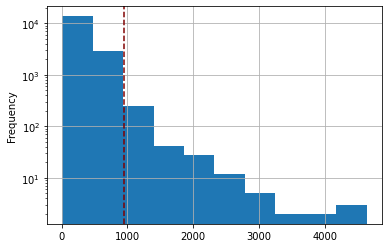

In [ ]:
length_th = 950
seq_data['seg_length'].plot.hist()
plt.axvline(length_th, ls = '--', color = 'maroon')
plt.yscale('log')
plt.grid()
plt.show()

<br>

Filter data by length

In [ ]:
seq_data = seq_data[seq_data['seg_length'] <= length_th]

In [ ]:
ec_encoder = LabelEncoder()
seq_data.loc[:,'ECLabel'] = ec_encoder.fit_transform(seq_data['ECNumber'])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
print(seq_data.shape)

(16660, 8)


In [ ]:
seq_data.head()

,ECNumber,Level_1,Level_2,Level_3,Level_4,sequence,seg_length,ECLabel
0,1,1,NaN,NaN,NaN,TKDNLTGDIVIIGAGAAGSLLAHYLARFSNMKIILLEAGHSHFNDP...,652,0
1,1,1,NaN,NaN,NaN,MHHHHHHSSGVDLGTENLYFQSNAMNISRKTALVTGASRGIGRAIA...,269,0
2,1,1,NaN,NaN,NaN,QGMIMTSDIKLLDYLRVRRSTPALQLSEPGPSKGEIEEILRLAVRV...,197,0
3,1,1,NaN,NaN,NaN,AMVSSSCSSIPKMPVTPLSLVTRHVAIIGAGAAGLVTARELRREGH...,458,0
4,1,1,NaN,NaN,NaN,MADLNQRRQRSEFQSKIKILLSTTIKAKPELVPSLLKLALNDAMTY...,268,0


<br>

## Create dataset

In [ ]:
class protDataset(Dataset):
    def __init__(self, labels, sequences, tokens):
        super().__init__()
        assert len(labels) == len(sequences)
        assert len(labels) == tokens.shape[0]
        
        # Add dataset size
        self.n = len(labels)

        # Add labels and token to class
        self.labels = torch.as_tensor(labels)
        self.tokens = tokens

        # Get sequences lengths
        lengths = [len(seq) for seq in sequences]
        self.lengths = torch.as_tensor(lengths)
            
    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return self.labels[idx], self.lengths[idx], self.tokens[idx,:]

In [ ]:
cols = ['ECLabel', 'sequence']
seq_data_list = seq_data[cols].values.tolist()
labels, sequences, tokens = batch_converter(seq_data_list)
dataset = protDataset(labels, sequences, tokens)

In [ ]:
print(len(dataset))

16660


<br>

## Get sequence representations

In [ ]:
class sequenceEmbedder():
    def __init__(self, model, dataset, batch_size = 16, num_layers = 33, device = 'cuda'):
        self.device = device
        self.model = model
        self.num_layers = num_layers
        self.batch_size = batch_size

        # Initiate data loader
        self.loader = DataLoader(
            dataset, 
            batch_size=self.batch_size,
            shuffle = False
        )
        
        # Set to eval model
        self.model.eval()

        # Set device
        if self.device == torch.device('cuda'):
            torch.cuda.empty_cache()
        self.model.to(device)

    def average_tokens(self, lengths, representations):
        seq_reps = []
        for i, l in enumerate(lengths):
            k = l + 1
            representation = representations[i]           
            r = representation[1:k,:].mean(0)
            seq_reps.append(r)
        seq_reps = torch.stack(seq_reps)
        return seq_reps

    def get_embeddings(self, verbosity = 100):
        # Init containers         
        embeddings = [] 
        all_labels = []        
        with torch.no_grad():
            start = time.time()
            for i, (labels, lengths, tokens) in enumerate(self.loader):
                # Set device
                tokens = tokens.to(device)

                # Get ESM results
                res = self.model(
                    tokens, 
                    repr_layers = [self.num_layers], 
                    return_contacts = False
                )

                # Extract token representations
                token_representations = res['representations'][self.num_layers]

                # Average across tokens
                sequence_representations = self.average_tokens(lengths, token_representations)

                # Detach and bring to cpu (unload gpu)
                sequence_representations = sequence_representations.detach().cpu()

                # Add to containers
                embeddings.append(sequence_representations)
                all_labels.append(labels)

                if i % verbosity == 0:
                    print('Batch no. {}; Sequence no.: {}; Elapsed time: {:1.2f}'.format(i + 1, (i + 1) * self.batch_size, time.time() - start))

            # Concat
            embeddings = torch.cat(embeddings)
            all_labels = torch.cat(all_labels)

        return embeddings, all_labels





In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
embedder = sequenceEmbedder(esm_model, dataset, batch_size = 32, device = device)

In [ ]:
embeddings, labels = embedder.get_embeddings(verbosity = 5)

Batch no. 1; Sequence no.: 32; Elapsed time: 7.87
Batch no. 6; Sequence no.: 192; Elapsed time: 46.51
Batch no. 11; Sequence no.: 352; Elapsed time: 85.19
Batch no. 16; Sequence no.: 512; Elapsed time: 123.89
Batch no. 21; Sequence no.: 672; Elapsed time: 162.56
Batch no. 26; Sequence no.: 832; Elapsed time: 201.20
Batch no. 31; Sequence no.: 992; Elapsed time: 239.84
Batch no. 36; Sequence no.: 1152; Elapsed time: 278.46
Batch no. 41; Sequence no.: 1312; Elapsed time: 317.08
Batch no. 46; Sequence no.: 1472; Elapsed time: 355.68
Batch no. 51; Sequence no.: 1632; Elapsed time: 394.31
Batch no. 56; Sequence no.: 1792; Elapsed time: 432.95
Batch no. 61; Sequence no.: 1952; Elapsed time: 471.59
Batch no. 66; Sequence no.: 2112; Elapsed time: 510.21
Batch no. 71; Sequence no.: 2272; Elapsed time: 548.85
Batch no. 76; Sequence no.: 2432; Elapsed time: 587.53
Batch no. 81; Sequence no.: 2592; Elapsed time: 626.14
Batch no. 86; Sequence no.: 2752; Elapsed time: 664.75
Batch no. 91; Sequence n

<br>

## Save the results

<br>

Post-process results

In [ ]:
embeddings = embeddings.numpy()

In [ ]:
labels = ec_encoder.inverse_transform(labels.numpy()).tolist()

<br>

Wrap-up into dictionary


In [ ]:
seq_embedding_output = {
    "seq_embeddings" : embeddings, 
    "seq_data" : seq_data
}

<br>

Dump to pickle file

In [ ]:
# output_file = '/content/drive/Othercomputers/My MacBook Pro/MIE1517_nlp_proteins/embeddings/esm_embeddings.p' #Tomas dir
output_file = '/content/drive/MyDrive/Colab Notebooks/Protein Sequence Analysis/esm_embeddings.p' #Rana dir
with open(output_file, 'wb') as f:
    pickle.dump(seq_embedding_output, f)